In [2]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors.kde import KernelDensity
from sklearn.cross_validation import train_test_split
import pandas as pd
from sklearn.linear_model import Ridge
import seaborn as sns
from __future__ import division
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.covariance import empirical_covariance

In [3]:
plt.close()
df = pd.read_csv("DesignMatrix.csv")
input = df.as_matrix()
X = input[:,1:-1]
Y = input[:,-1:]



In [4]:
X_scaled = scale(X)
#Y_scaled = scale(Y)
#scaler = StandardScaler().fit(X)
#X_trans = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size =500, random_state=5)

In [5]:
print X.shape 
print Y.shape

(3998, 84)
(3998, 1)


### Experiments with sample data generated

In [3]:
mu, sigma = 0, 1.

In [4]:
#Generating design matrix

X = np.random.normal(mu,sigma,300).reshape(100,3)

In [5]:
y = np.random.lognormal(mu, sigma, 100)

In [6]:
y = np.reshape(y,(y.shape[0],1))
y.shape

(100, 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =30, random_state=5)

<IPython.core.display.Javascript object>


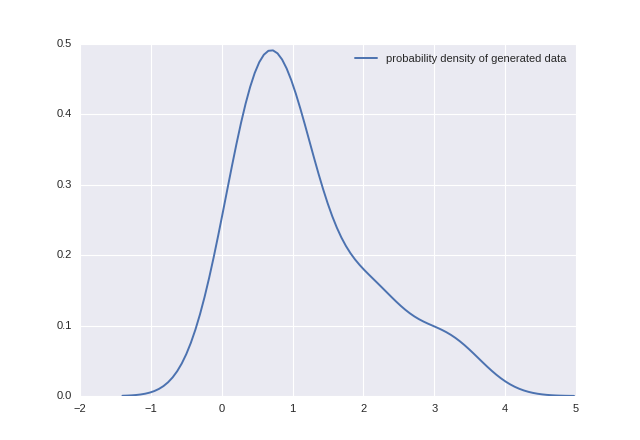

In [8]:
plt.close()
sns.distplot(y_test,hist=False,label='probability density of generated data')

In [100]:
class Heavy_tail_ridge(Ridge):
    def __init__(self, alpha=1.0, fit_intercept=True, normalize=False,
                 copy_X=True, max_iter=None, tol=1e-3, solver="auto",
                 random_state=None, delta = 0.2, c = 5):
        
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.max_iter = max_iter
        self.tol = tol
        self.solver = solver
        self.random_state = random_state
        self.delta = delta
        self.c = c
        self.models = []
        self.num_of_samples = 0
        self.coef_ = []
        
        
    def fit(self,X,y):
        model_w_vectors = []
        covariance_factor = []
        medians = []
        w = []
        ridge = Ridge(self.alpha, self.fit_intercept, self.normalize,
                 self.copy_X, self.max_iter, self.tol, self.solver,
                 self.random_state)
        #self.num_of_samples = np.ceil(self.c * np.log(1/self.delta))
        self.num_of_samples = 7
        X_samples, y_samples = self._get_samples(X,y,self.num_of_samples)
        sample_size = np.floor(X.shape[0]/self.num_of_samples)
        
        for i in range(len(X_samples)):
            clf = ridge.fit(X_samples[i],y_samples[i])
            self.models.append(clf)
            model_w_vectors.append(self.models[i].coef_)
        
        sigma_cov = empirical_covariance(X)
        print sigma_cov
        #covariance_factor.append((1/(X_samples[i].shape[0])) * (np.vdot(X_samples[i],X_samples[i])))
        for i in range(len(self.models)):
            dist_list = []
            for j in range(len(self.models)):
                if (i == j):
                    continue
                else:
                    dv = model_w_vectors[i] - model_w_vectors[j]
                    distance = np.dot(dv,np.dot((sigma_cov + np.eye(X.shape[1])*self.alpha),dv.T))
                    '''
                    cov = covariance_factor[j] + self.alpha
                    distance = cov * np.vdot(distance_vector,distance_vector)
                    '''
                    dist_list.append(distance)
            print (np.where( dist_list < 0 ))[0]
            medians.append(np.median(dist_list))
                    
        least_median_idx = np.argmin(medians)
        self.coef_ = np.array(model_w_vectors[least_median_idx])
        print self.coef_
        return self
    
    def predict(self,X):
        res = np.dot(self.coef_,X.T)
        return np.array(res[0])
    
    def _get_samples(self,X,y,num_of_samples):
        X, y = self._shuffle_data(X,y)
        instances = y.shape[0]
        extras = instances % num_of_samples
        if (extras != 0):
            X = X[:instances - extras,:]
            y = y[:instances - extras,:]
        return np.split(X,num_of_samples), np.split(y,num_of_samples)
        
    def _shuffle_data(self,X,y):
        permutation = np.random.permutation(X.shape[0])
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]
        return X_shuffled,y_shuffled
    
    '''
    def score(self, X, y, sample_weight=None):
        y_t = y
        y_p = self.predict(X,y)
        r,c = y_t.shape
        J = y_p - y_t
        loss = np.divide(J,y_t)
        meanLoss = np.sum(np.square(loss))/r
        return meanLoss
    
    '''
    def score(self, X, y, sample_weight=None):
        return r2_score(y, self.predict(X), sample_weight=sample_weight,
                        multioutput='variance_weighted')

    
        

In [101]:
pipe = Pipeline([
    ('heavy_tail', Heavy_tail_ridge()),
])

parameters = {
    'heavy_tail__alpha': (0.00001, 0.001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000, 100000 ),
    'heavy_tail__delta': (0.1,0.2,0.3,0.4)
}

grid_search = GridSearchCV(pipe, parameters, n_jobs=-1, verbose=1, cv = 10)

In [102]:
gr = grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[[ 0.93717846 -0.1238959  -0.09347272]
 [-0.1238959   1.27965898 -0.05274819]
 [-0.09347272 -0.05274819  1.01178289]]
[]
[]
[]
[]
[]
[]
[]
[[ 0.11277783 -0.24964369 -0.4230585 ]]
[[ 0.9917786  -0.19631313 -0.12685036]
 [-0.19631313  1.27833956 -0.00742518]
 [-0.12685036 -0.00742518  0.94247892]]
[]
[]
[]
[]
[]
[]
[]
[[ 0.51031532 -0.13877447  0.70429276]]
[[ 0.98811076 -0.10247141 -0.12480207]
 [-0.10247141  1.24907023 -0.0568577 ]
 [-0.12480207 -0.0568577   1.03187561]]
[]
[]
[]
[]
[]
[]
[]
[[ 0.14494149  0.04387215  0.01692407]]
[[ 0.94198171 -0.16301845 -0.0719865 ]
 [-0.16301845  1.17680155 -0.06461324]
 [-0.0719865  -0.06461324  1.00637186]]
[]
[]
[]
[]
[]
[]
[]
[[ 0.0531662  -0.13613858 -0.2237649 ]]
[[ 1.02890629 -0.12542077 -0.13165094]
 [-0.12542077  1.26848356 -0.06338669]
 [-0.13165094 -0.06338669  1.07684784]]
[]
[]
[]
[]
[]
[]
[]
[[ 0.84622751  1.12107407  0.21701527]]
[[ 1.00412384 -0.10313254 -0.14966918]
 [-

[Parallel(n_jobs=-1)]: Done  49 tasks       | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 199 tasks       | elapsed:    1.8s



[]
[]
[]
[]
[]
[]
[]
[[-0.11462812  0.61134208 -0.32887318]]
[[ 1.02890629 -0.12542077 -0.13165094]
 [-0.12542077  1.26848356 -0.06338669]
 [-0.13165094 -0.06338669  1.07684784]]
[]
[]
[]
[]
[]
[]
[]
[[ 0.1201888   0.39256519 -0.51037379]]
[[ 1.00412384 -0.10313254 -0.14966918]
 [-0.10313254  1.08645493 -0.00620046]
 [-0.14966918 -0.00620046  0.86689294]]
[]
[]
[]
[]
[]
[]
[]
[[ 0.26059787 -0.03690665 -0.22886862]]
[[ 1.05531255 -0.17774368 -0.16604087]
 [-0.17774368  1.1833706  -0.026708  ]
 [-0.16604087 -0.026708    0.98437524]]
[]
[]
[]
[]
[]
[]
[]
[[-0.16057971  0.06748759 -0.33607039]]
[[ 1.00249517 -0.2744927  -0.16153778]
 [-0.2744927   1.13515162 -0.01479618]
 [-0.16153778 -0.01479618  0.92747127]]
[]
[]
[]
[]
[]
[]
[]
[[-0.08823964  0.86643465 -0.61223519]]
[[ 0.84506488 -0.15732328 -0.20507713]
 [-0.15732328  1.28281347 -0.01724702]
 [-0.20507713 -0.01724702  1.04161189]]
[]
[]
[]
[]
[]
[]
[]
[[ 0.42159371  0.0317371   0.00812604]]
[[ 1.01459138 -0.15776121 -0.17605453]
 [-0

[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    3.9s finished


In [103]:
gr.best_params_ 

{'heavy_tail__alpha': 1e-05, 'heavy_tail__delta': 0.1}

In [104]:
gr.best_score_

-1.9286827361681746

In [105]:
gr.predict(X_test)

array([ 0.21560355,  1.27423708, -0.03204319,  0.54062178,  1.33917782,
       -0.07485748,  0.082075  , -0.13064239,  0.38340899, -0.68979768,
       -1.0091183 , -0.00168747,  0.09667441, -0.44584714, -0.33472058,
        0.2136701 , -0.5619596 , -1.62890568,  0.6690292 , -0.47426453,
       -0.40318405, -0.15267567,  1.02562597, -0.49671054,  1.64428185,
       -0.39375046, -0.71129668,  0.06903665,  0.20964001,  0.56831425])

In [106]:
clf = Heavy_tail_ridge(alpha = 0.01)

In [107]:
clf.fit(X_train,y_train)

[[ 0.98180742 -0.15858522 -0.14068404]
 [-0.15858522  1.2285297  -0.04064846]
 [-0.14068404 -0.04064846  0.99108735]]
[]
[]
[]
[]
[]
[]
[]
[[ 0.3956789  -0.1117132   0.10797117]]


Heavy_tail_ridge(alpha=0.01, c=5, copy_X=True, delta=0.2, fit_intercept=True,
         max_iter=None, normalize=False, random_state=None, solver='auto',
         tol=0.001)

In [108]:
len(clf.models)

7

-0.639212664146 -1.47120011867


<IPython.core.display.Javascript object>


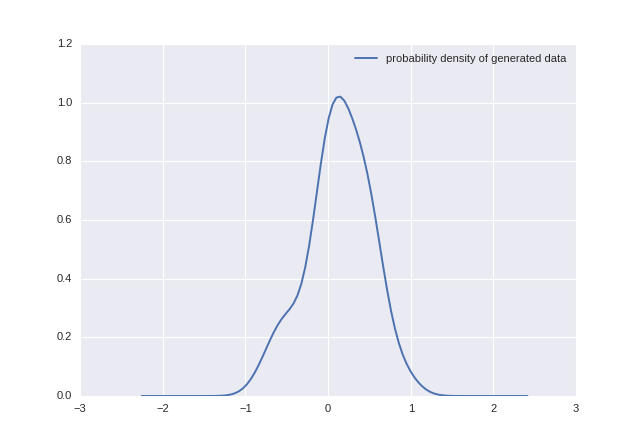

In [109]:
plt.close()
train_score = clf.score(X_train,y_train)
test_score = clf.score(X_test,y_test)

print train_score, test_score
s = clf.predict(X_test)

sns.distplot(s,hist=False,label='probability density of generated data')

In [111]:
clf.score(X_test,y_test)

-1.4712001186713937

In [115]:
y_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

In [117]:
from sklearn.metrics import mean_squared_error

print mean_squared_error(y_test,y_pred)
print mean_squared_error(y_train,y_train_pred)

1.98261544312
7.62046303117


In [34]:
print s[0]

[-0.3859194   0.44385137 -0.14578821  0.47346243  0.11849761 -0.25632525
  0.75290865  0.55000766 -0.00592249 -0.00746179  0.22365273 -0.14149381
 -0.42736917 -0.2267179   0.7126032   0.66413072 -0.30473351 -0.64450734
  0.67746123  0.08886295 -1.25141575 -0.01466304 -0.1746431   0.08062629
  0.82829696 -0.44762797  0.38057749  0.00590036 -0.26502979  0.29711448]


In [35]:
for i in range(len(s[0])):
    print "predicted: ", s[0][i] , "  actual: ", y_test[i]

predicted:  -0.385919399882   actual:  [ 0.11868862]
predicted:  0.443851373789   actual:  [ 0.27901083]
predicted:  -0.145788207564   actual:  [ 1.26436825]
predicted:  0.473462425127   actual:  [ 0.47611771]
predicted:  0.11849761213   actual:  [ 0.82897265]
predicted:  -0.256325252269   actual:  [ 2.15697688]
predicted:  0.752908654163   actual:  [ 3.45218168]
predicted:  0.550007664802   actual:  [ 0.71632076]
predicted:  -0.00592248577   actual:  [ 0.30002003]
predicted:  -0.00746179068447   actual:  [ 3.00286981]
predicted:  0.223652727909   actual:  [ 0.62084353]
predicted:  -0.141493813996   actual:  [ 3.07358598]
predicted:  -0.42736916718   actual:  [ 1.24587775]
predicted:  -0.226717902463   actual:  [ 0.82636058]
predicted:  0.712603201549   actual:  [ 0.25586512]
predicted:  0.664130721367   actual:  [ 2.28220608]
predicted:  -0.304733508953   actual:  [ 0.70922535]
predicted:  -0.644507337835   actual:  [ 0.18802647]
predicted:  0.677461226003   actual:  [ 0.92505222]
pre